In [1]:
# Settings
settings = {}
settings['basemap_csv'] = 'input/scopus2basemap.csv'
settings['background_image'] = r"input/bw-background.jpg"
settings['font'] = "Inconsolata-Light.ttf"
baseName = 'example data'
settings['keywords_file'] = 'input/' + baseName + '.csv'
settings['keywords_weights_file'] = 'input/kw-everything.csv'
settings['canvas_size'] = 3200
settings['stat_test_min'] = 30
settings['barycenter_offset_x'] = -70
settings['barycenter_offset_y'] = 25
settings['scale_ratio'] = 0.273
settings['output_file_basename'] = 'output/'+baseName

In [2]:
# Loads and imports
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt
import math
import scipy.stats
!pip install coloraide
from coloraide.everything import ColorAll as Color
import pickle
from scipy.spatial import Voronoi

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Load nodes aka dots aka keywords
df = pd.read_csv(settings['basemap_csv']).replace({np.nan: None})
df

,Id,x,y,size,showlabel,key,label
0,Galaxy,125.326126,-740.643066,11.263846,False,Galaxy,Galaxy
1,Downlink,-4213.5625,-163.741669,11.263846,False,Downlink,Downlink
2,Eyes,2596.249756,941.393005,11.263846,False,Eyes,Eyes
3,Banach,-2335.763184,175.997345,11.263846,False,Banach,Banach
4,Dosimetric,2253.345215,433.17218,11.263846,False,Dosimetric,Dosimetric
...,...,...,...,...,...,...,...
7557,Feedback,-2047.289551,-663.29718,4.0,False,Feedback,Feedback
7558,Lowering,3246.678467,550.198181,4.0,False,Lowering,Lowering
7559,Usual,3537.695557,911.690796,4.0,False,Usual,Usual
7560,durations,3355.917969,1520.114746,4.0,False,durations,durations


In [4]:
# Compute barycenter
barycenter_x = 0
barycenter_y = 0
count = 0
for index, row in df.iterrows():
    barycenter_x += row['x']
    barycenter_y += row['y']
    count += 1
barycenter_x = barycenter_x / count
barycenter_y = barycenter_y / count
print("Barycenter:",barycenter_x,barycenter_y)

Barycenter: 0.9214623407828252 -1.1867338028298926


In [5]:
# Check if key duplicates
keys = {}
duplicates = {}
for index, row in df.iterrows():
    key = row['key']
    if key in keys:
        print('Key', key, 'is a duplicate.')
        keys[key] = keys[key]+1
        duplicates[key] = 1
    else:
        keys[key] = 1
print('Done.')

Key Microbiology is a duplicate.
Key Convolutional neural network is a duplicate.
Key Maximum power point tracking is a duplicate.
Key Photovoltaic is a duplicate.
Key Neurology is a duplicate.
Key Wireless sensor networks is a duplicate.
Key Unmanned aerial vehicle is a duplicate.
Key Synthetic aperture radar is a duplicate.
Key Quality of service is a duplicate.
Key Magnetic resonance imaging is a duplicate.
Key Pharmacology is a duplicate.
Key Artificial neural network is a duplicate.
Key Particle swarm optimization is a duplicate.
Key Principal component analysis is a duplicate.
Key Differential evolution is a duplicate.
Key Nursing is a duplicate.
Key Internet of Things is a duplicate.
Key Psychology is a duplicate.
Key Evolution is a duplicate.
Key Energy is a duplicate.
Key Genetic algorithm is a duplicate.
Key Physiology is a duplicate.
Key Monitoring is a duplicate.
Key Support vector machine is a duplicate.
Key Genetics is a duplicate.
Key Chemistry is a duplicate.
Key None i

In [6]:
# Drop duplicates
df = df.drop_duplicates(subset=['key'])
print('Duplicates removed.', len(df), 'rows remaining.')

Duplicates removed. 7534 rows remaining.


In [7]:
# Load k-means centroids
centroids = pickle.load( open( "cache/centroids.pkl", "rb" ) )
kmeans_k = len(centroids)
print(kmeans_k, "k-means centroids loaded")

126 k-means centroids loaded


In [8]:
# Load dummy centroids
dummy_centroids = pickle.load( open( "cache/dummy_centroids.pkl", "rb" ) )
print(len(dummy_centroids), "dummy centroids loaded")

381 dummy centroids loaded


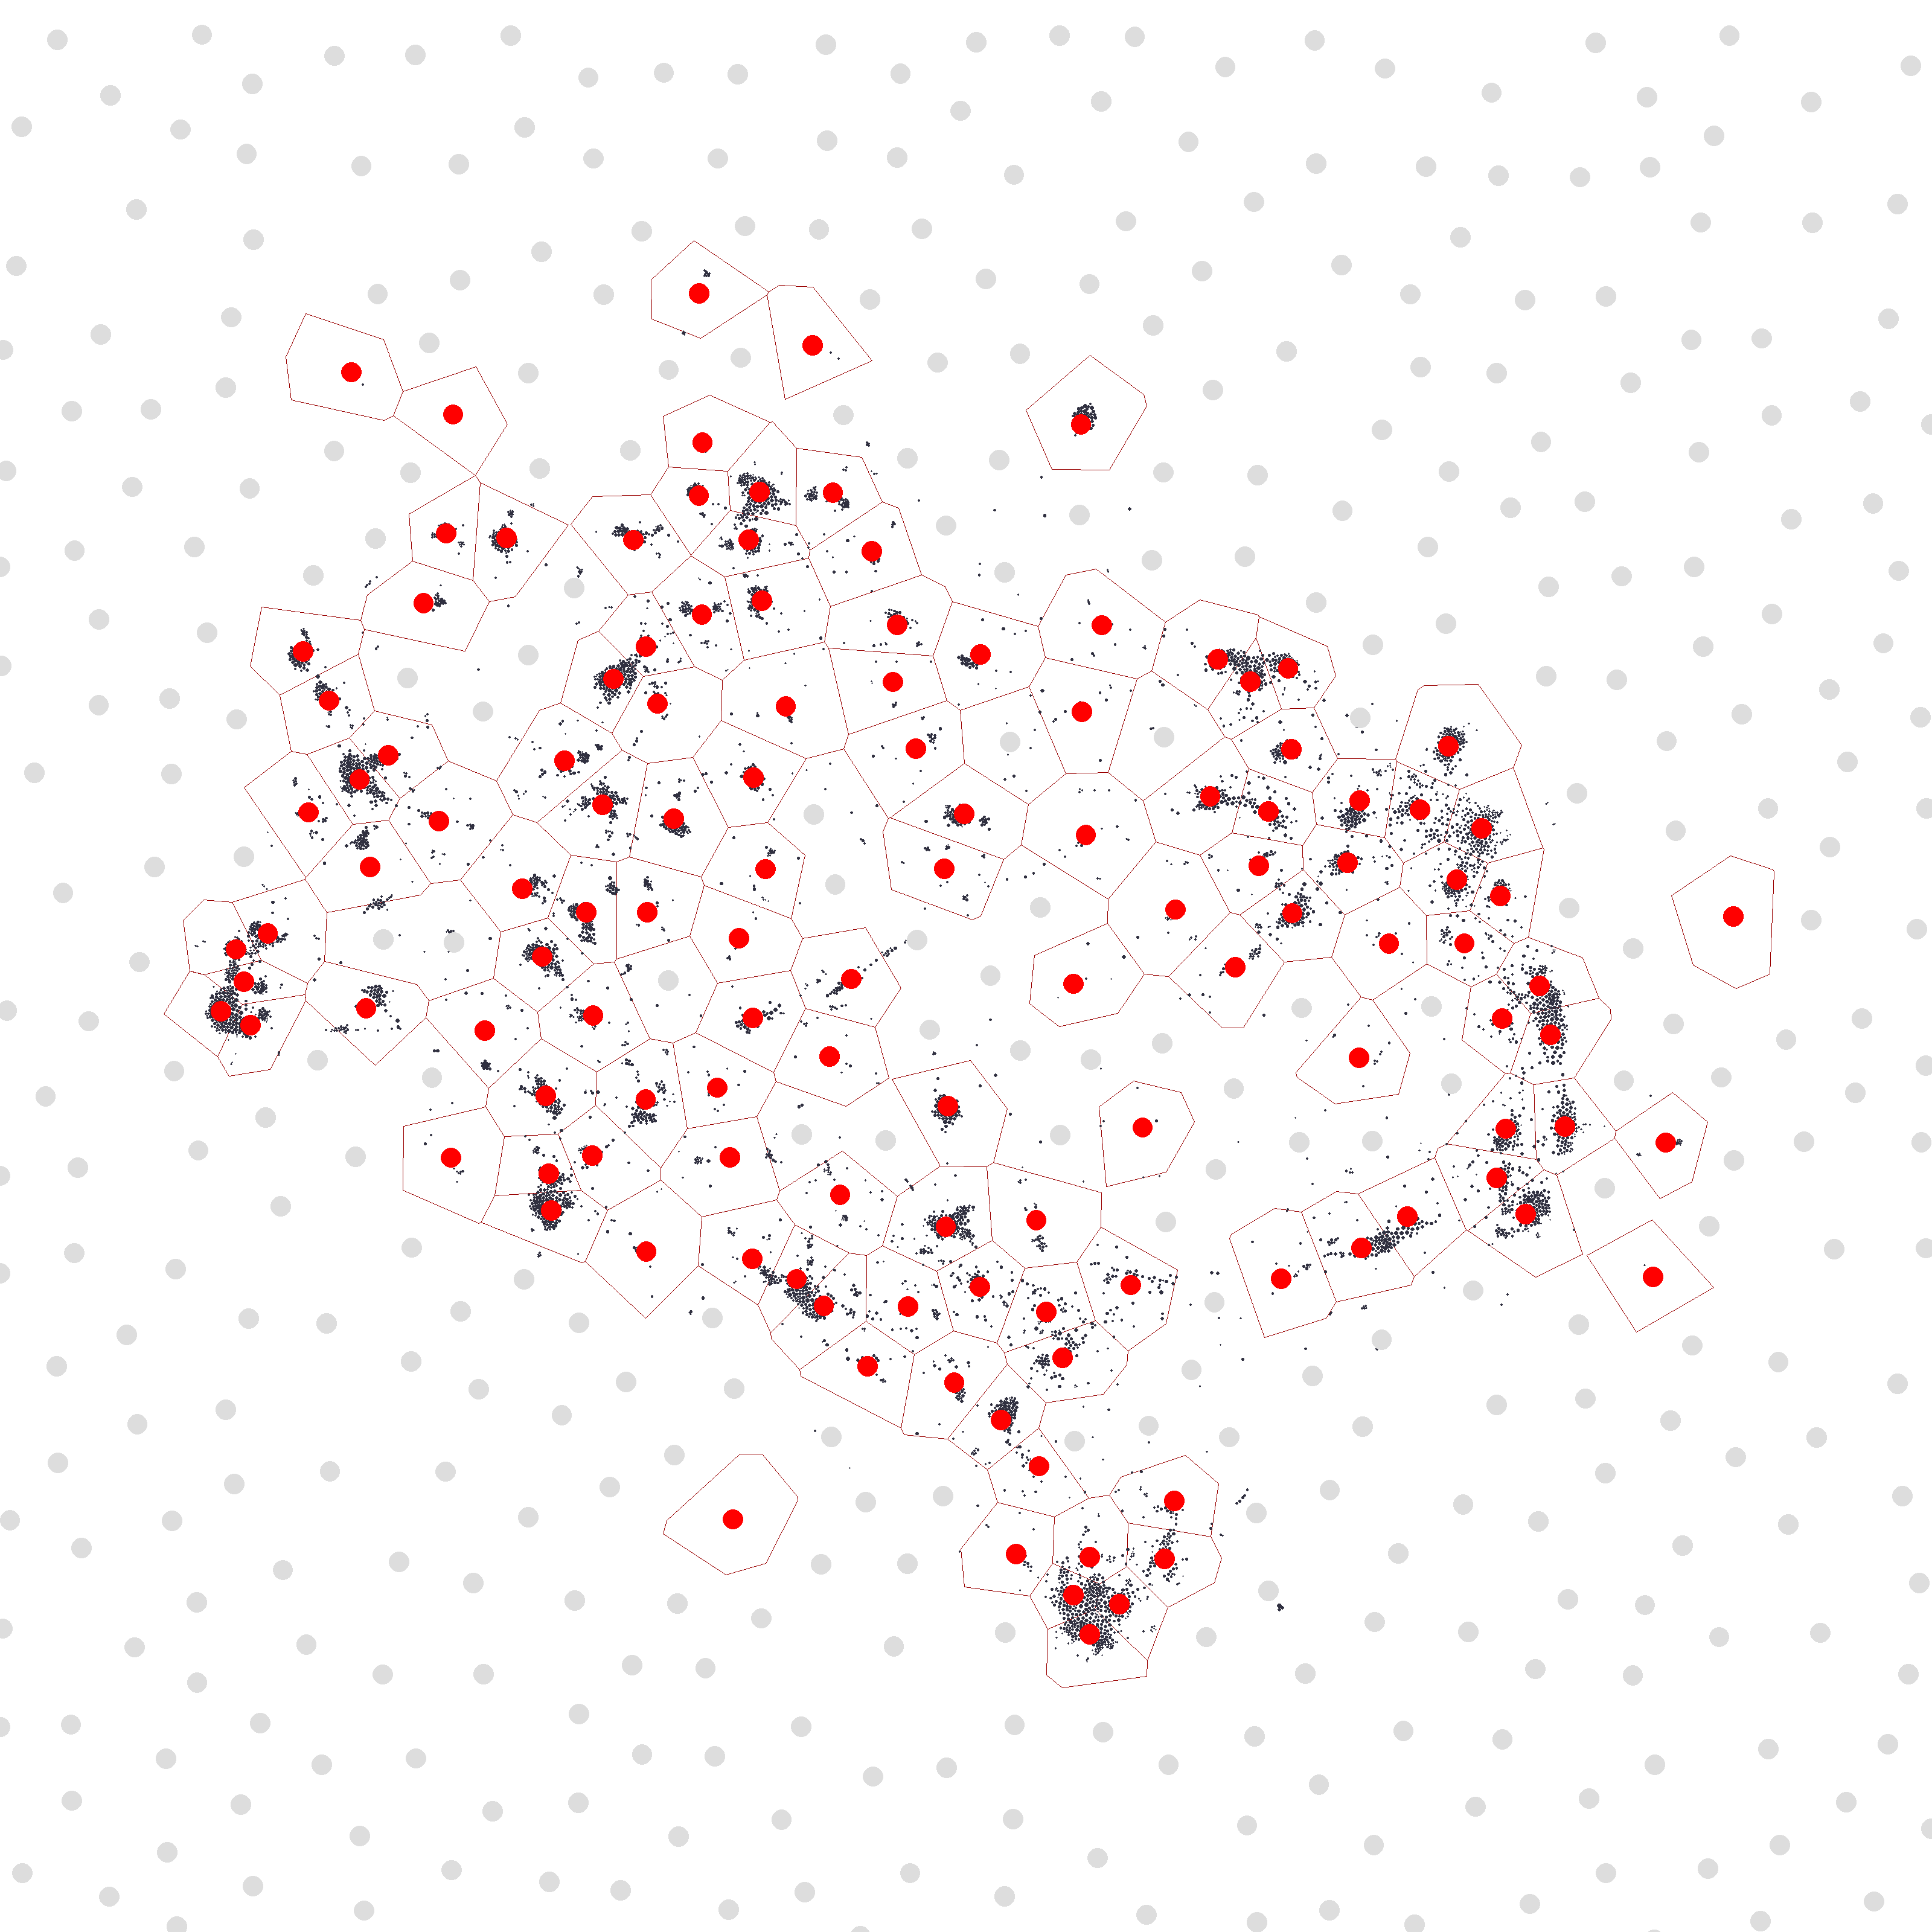

In [9]:
# Render basic visualization (basemap)
# (for monitoring purposes)

# Init canvas
width = settings['canvas_size']
height = settings['canvas_size']
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# Draw a circle
def draw_circle(center_x, center_y, radius, color):
    draw.ellipse([(center_x - radius, center_y - radius),
                  (center_x + radius, center_y + radius)], fill=color)

# Draw Voronoi
all_centroids = np.concatenate((centroids, dummy_centroids))
vor = Voronoi(all_centroids)
for i in range(len(centroids)):
    region = vor.regions[vor.point_region[i]]
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        xy = []
        for point in polygon:
            x = width/2 + ((point[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
            y = height/2 + (-(point[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
            x = max(0, min(width, x))
            y = max(0, min(height, y))
            xy.append(x)
            xy.append(y)
        draw.polygon(xy, fill="#FFFFFF", outline="#990000")

# Draw nodes
for index, row in df.iterrows():
    x = width/2 + ((row['x'] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(row['y'] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * row['size']
    draw_circle(x, y, r, "#303040")

# Draw centroids
for c in centroids:
    x = width/2 + ((c[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(c[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * 60
    draw_circle(x, y, r, "#FF0000")

# Draw dummy centroids
for c in dummy_centroids:
    x = width/2 + ((c[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(c[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * 60
    draw_circle(x, y, r, "#DDDDDD")

# Base map
image.save("output/basemap_centroids.jpg", "JPEG")
    
display(image)

In [10]:
# Load weight of keyword nodes
wdf = pd.read_csv(settings['keywords_weights_file']).replace({np.nan: None})
wdf

,key,doc_count
0,Biochemistry,28143
1,Multidisciplinary,27961
2,Energy Engineering and Power Technology,26713
3,Statistics and Probability,26191
4,Molecular Biology,20053
...,...,...
6200,wings,1
6201,workloads,1
6202,workpiece,1
6203,worldwide,1


In [11]:
# Build weight index
windex = {}
# Init
for index, row in df.iterrows():
    windex[row['key']] = 0
# Weights we have
for index, row in wdf.iterrows():
    weight = row['doc_count']
    windex[row['key']] = weight
print('Done.')

Done.


In [12]:
# Add weights to the dataframe and remove those with null weight.

# Adding a new column "weight" to the DataFrame
df['weight'] = df['key'].copy().map(windex)

# Removing rows with a weight of 0
df = df[df['weight'].copy() != 0]

print('Weights added and rows with empty weights removed.')
df

Weights added and rows with empty weights removed.


C:\Users\Mathieu\AppData\Local\Temp\ipykernel_27056\882304267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['key'].copy().map(windex)


,Id,x,y,size,showlabel,key,label,weight
0,Galaxy,125.326126,-740.643066,11.263846,False,Galaxy,Galaxy,26
1,Downlink,-4213.5625,-163.741669,11.263846,False,Downlink,Downlink,124
2,Eyes,2596.249756,941.393005,11.263846,False,Eyes,Eyes,14
3,Banach,-2335.763184,175.997345,11.263846,False,Banach,Banach,1027
4,Dosimetric,2253.345215,433.17218,11.263846,False,Dosimetric,Dosimetric,179
...,...,...,...,...,...,...,...,...
7553,Prevented,3786.9021,1080.565186,4.0,False,Prevented,Prevented,1
7555,responsiveness,3261.756836,940.848389,4.0,False,responsiveness,responsiveness,7
7557,Feedback,-2047.289551,-663.29718,4.0,False,Feedback,Feedback,182
7558,Lowering,3246.678467,550.198181,4.0,False,Lowering,Lowering,1


In [13]:
# Load queried keyword nodes
qdf = pd.read_csv(settings['keywords_file']).replace({np.nan: None})
qdf

,key,doc_count
0,Twitter,65
1,COVID-19,35
2,AI,28
3,Social media,27
4,Facebook,25
...,...,...
263,mHealth,1
264,the Creative Commons Attribution,1
265,users,1
266,videos,1


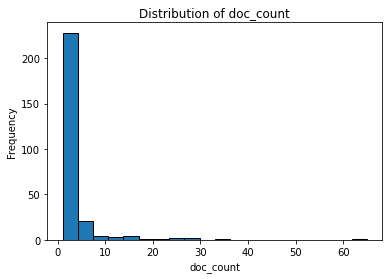

In [14]:
# Plot doc_count
plt.hist(qdf['doc_count'], bins=20, edgecolor='black')
plt.xlabel('doc_count')
plt.ylabel('Frequency')
plt.title('Distribution of doc_count')
plt.show()

In [15]:
# Check that all query keywords have a nonnull weight. It may happen very rarely.
for index, row in qdf.iterrows():
    if windex[row['key']]==0:
        print(row['key'], 'has a null weight and has to be removed from the query.')
        qdf.drop(index, inplace=True)
    
# Reset the index after deleting rows
qdf.reset_index(drop=True, inplace=True)
print('Done.')

Done.


In [16]:
# Normalize the doc_count into a different score
qdf['score'] = qdf.apply(lambda row: row['doc_count'] / windex[row['key']], axis=1)
print('Done.')

Done.


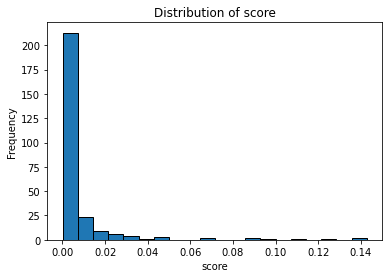

In [17]:
# Plot score
plt.hist(qdf['score'], bins=20, edgecolor='black')
plt.xlabel('score')
plt.ylabel('Frequency')
plt.title('Distribution of score')
plt.show()

In [18]:
# Monitoring: test whether it fits an exponential distribution
scipy.stats.kstest(qdf['score'], scipy.stats.expon.cdf)

KstestResult(statistic=0.9199148652812379, pvalue=2.8632340559221533e-294)

In [19]:
# Build keyword index
qindex = {}
total = 0
for index, row in qdf.iterrows():
    score = row['score']
    qindex[row['key']] = score
    total += score
average_score = total/len(df)
print("Average score:", average_score, 'for', len(df), 'items')

Average score: 0.00034696382908635983 for 6205 items


In [20]:
# Build cells
cells = []
for c in centroids:
    cells.append({})
# Fill
for index, row in df.iterrows():
    distances2 = [] # Distances squared
    for c in centroids:
        dx2 = row['x'] - c[0]
        dy2 = row['y'] - c[1]
        d2 = dx2*dx2 + dy2*dy2
        distances2.append(d2)
    d2Min = distances2[0]
    closest = 0
    for i in range(1, len(distances2)):
        d2 = distances2[i]
        if d2<d2Min:
            d2Min = d2
            closest = i
    cells[closest][row['key']] = 1
    print(index, row['Id'], '-> cluster', closest)

print('Done.')

0 Galaxy -> cluster 44
1 Downlink -> cluster 119
2 Eyes -> cluster 95
3 Banach -> cluster 59
4 Dosimetric -> cluster 52
5 Spectroradiometer -> cluster 26
6 Censored -> cluster 62
7 vertices -> cluster 24
8 MOEAs -> cluster 38
9 Stromal -> cluster 69
10 DC-link -> cluster 27
11 CNNs -> cluster 25
12 IMU -> cluster 86
13 Inertial -> cluster 86
14 Navier-Stokes -> cluster 11
17 Selling -> cluster 12
18 Interval-valued -> cluster 35
19 Intuitionistic -> cluster 35
20 Binding -> cluster 99
21 Local_binary_pattern -> cluster 102
23 AlexNet -> cluster 25
24 carcinomas -> cluster 69
25 sliding-mode -> cluster 39
26 flexions -> cluster 10
29 rocks -> cluster 67
31 Whole-brain -> cluster 109
32 tensile -> cluster 0
33 accelerators -> cluster 92
34 authors -> cluster 43
36 MODIS -> cluster 26
37 Ophthalmology -> cluster 95
38 sum-rate -> cluster 119
40 Prefrontal -> cluster 109
41 Laminar -> cluster 84
42 Reynolds -> cluster 84
43 Uplink -> cluster 119
44 Radiotherapy -> cluster 52
45 Galactic ->

359 Psychiatry_and_Mental_Health -> cluster 28
360 Malignancy -> cluster 22
361 Co-expression -> cluster 42
362 Psychiatric -> cluster 28
363 compressible -> cluster 11
364 WM -> cluster 109
365 Contrast-enhanced -> cluster 18
366 Musculoskeletal -> cluster 10
367 Distal -> cluster 96
369 Lyapunov -> cluster 39
370 Quadrotor -> cluster 88
371 Underactuated -> cluster 7
372 Chl-a -> cluster 48
375 vasculature -> cluster 95
376 Multiobjective_optimization -> cluster 38
377 multiobjective -> cluster 38
378 NSGA-II -> cluster 38
379 Decomposition-based -> cluster 38
380 Elitist -> cluster 38
381 Extended_Kalman_filter -> cluster 86
382 proteins -> cluster 99
383 Subgradient -> cluster 59
385 Nonconvex -> cluster 59
386 Handcrafted -> cluster 25
387 Metastatic -> cluster 69
388 CPUs -> cluster 8
389 FPGAs -> cluster 92
391 preference -> cluster 35
392 Iterative_reconstruction -> cluster 33
393 TPS -> cluster 52
394 Dual-energy -> cluster 33
395 quality-of-service -> cluster 119
396 Financia

713 metamaterials -> cluster 45
714 Microvascular -> cluster 95
715 miRNAs -> cluster 42
716 Oncology -> cluster 69
717 GEO -> cluster 69
718 Social_media -> cluster 75
719 Text_mining -> cluster 20
720 Auditory -> cluster 102
721 Initio -> cluster 29
722 Face_recognition -> cluster 102
723 face -> cluster 102
724 Convolutional_neural_network -> cluster 25
725 TV -> cluster 19
726 genomics -> cluster 49
728 first-principles -> cluster 29
729 Ionic -> cluster 29
730 Gray-level -> cluster 102
731 Facial -> cluster 102
732 Physicochemical -> cluster 30
733 Ethanol -> cluster 110
734 Proximal -> cluster 59
735 trade -> cluster 12
736 biometrics -> cluster 38
737 lake -> cluster 48
738 Diurnal -> cluster 26
739 Blinded -> cluster 33
740 Scrambling -> cluster 17
741 inpatients -> cluster 54
742 HetNets -> cluster 119
743 UE -> cluster 119
744 Multi-hop -> cluster 93
746 microRNA -> cluster 42
748 covariates -> cluster 62
749 Normality -> cluster 62
750 GPU -> cluster 8
753 deadline -> cluste

1069 Surface_roughness -> cluster 120
1070 roughness -> cluster 120
1072 Flexural -> cluster 0
1073 concrete -> cluster 0
1074 Bending -> cluster 0
1075 Graphics_processing_unit -> cluster 8
1076 Parallelization -> cluster 8
1077 MPI -> cluster 8
1078 interference -> cluster 119
1079 cross-layer -> cluster 93
1080 Atmospheric -> cluster 26
1081 latitude -> cluster 26
1082 Geostationary -> cluster 26
1083 Survival_analysis -> cluster 62
1084 Log-likelihood -> cluster 62
1086 Neutrosophic -> cluster 35
1087 DMs -> cluster 35
1088 sarcomas -> cluster 22
1089 Chromosomal -> cluster 49
1090 Prosthesis -> cluster 10
1091 cubature -> cluster 86
1092 MCI -> cluster 109
1093 Interviews -> cluster 28
1094 symptoms -> cluster 28
1095 illness -> cluster 95
1096 MeV -> cluster 52
1097 WOA -> cluster 66
1098 timetable -> cluster 19
1099 Cardinality -> cluster 24
1100 Local_search -> cluster 34
1101 Unmanned -> cluster 84
1102 SMC -> cluster 39
1103 LMI -> cluster 39
1105 Philosophy -> cluster 75
110

1426 Pendulum -> cluster 39
1427 Multitemporal -> cluster 48
1428 Mediterranean -> cluster 76
1429 Perturb -> cluster 27
1430 Islanded -> cluster 64
1431 rotors -> cluster 27
1432 recommender -> cluster 56
1433 composite -> cluster 0
1434 shortage -> cluster 12
1435 Company -> cluster 12
1436 Multimodal -> cluster 66
1437 co-occurrence -> cluster 102
1438 brands -> cluster 56
1439 FER -> cluster 102
1440 HOG -> cluster 102
1441 Titanium -> cluster 120
1442 Metro -> cluster 19
1443 Prey -> cluster 14
1444 Parameterized -> cluster 24
1446 Phase-shifting -> cluster 105
1447 fringe -> cluster 105
1449 Dark -> cluster 44
1450 gratings -> cluster 105
1451 LV -> cluster 13
1452 Comorbidity -> cluster 54
1453 ICU -> cluster 54
1454 Gut -> cluster 6
1455 Taxonomic -> cluster 6
1456 Biodiversity -> cluster 100
1457 Recombinant -> cluster 6
1458 Hepatocellular_carcinoma -> cluster 69
1460 Chromatin -> cluster 42
1461 Computed_tomography -> cluster 33
1462 deformable -> cluster 52
1463 Virtualizat

1768 Recommendation_system -> cluster 56
1769 sparse -> cluster 19
1770 Heritability -> cluster 49
1771 Diesel -> cluster 110
1772 L1 -> cluster 19
1773 Compressed_sensing -> cluster 19
1774 Zn -> cluster 40
1775 Compressed -> cluster 79
1776 Organizational -> cluster 89
1777 RBM -> cluster 25
1778 Russia -> cluster 124
1779 consumers -> cluster 12
1780 Geothermal -> cluster 105
1781 transmembrane -> cluster 99
1782 Pharmacological -> cluster 99
1783 Intracellular -> cluster 6
1784 Semantic_segmentation -> cluster 25
1785 Indentation -> cluster 0
1786 Inception -> cluster 25
1787 H2O -> cluster 29
1788 Lagrangian -> cluster 83
1789 Brain-computer_interface -> cluster 36
1790 CSF -> cluster 109
1791 Magnetic_resonance_imaging -> cluster 55
1793 Psychosis -> cluster 28
1794 Arousal -> cluster 36
1797 Naive_Bayes -> cluster 5
1798 undergraduate -> cluster 106
1799 Political_Science_and_International_Relations -> cluster 75
1800 Information_retrieval -> cluster 20
1802 Legal -> cluster 75


2133 constellations -> cluster 21
2134 Opportunistic -> cluster 37
2135 Unmanned_aerial_vehicle -> cluster 84
2136 Flying -> cluster 84
2137 NNs -> cluster 39
2138 UAS -> cluster 61
2139 Distributed_control -> cluster 39
2140 spike -> cluster 36
2142 questionnaire -> cluster 28
2143 genre -> cluster 35
2144 Radiofrequency -> cluster 55
2145 Verbal -> cluster 28
2146 Wheat -> cluster 100
2147 fertilizer -> cluster 100
2148 Food_Science -> cluster 4
2149 AGB -> cluster 48
2150 pH -> cluster 110
2151 seawater -> cluster 26
2152 IOP -> cluster 26
2153 Asia -> cluster 76
2154 microbiome -> cluster 6
2155 EVs -> cluster 7
2156 Induction -> cluster 27
2157 Settling -> cluster 64
2158 Unbalanced -> cluster 27
2159 Residential -> cluster 7
2160 Smart_grid -> cluster 7
2161 PLL -> cluster 27
2162 Semi-supervised_learning -> cluster 71
2163 Semisupervised -> cluster 71
2164 Manifold_learning -> cluster 121
2165 penalties -> cluster 14
2166 Markov -> cluster 62
2168 copulas -> cluster 62
2169 Chao

2462 Gastrointestinal -> cluster 22
2463 GC -> cluster 69
2464 collision-free -> cluster 31
2465 cartilage -> cluster 96
2466 Elderly -> cluster 10
2467 ADL -> cluster 10
2469 contigs -> cluster 49
2470 Chromatographic -> cluster 115
2471 Metabolism -> cluster 6
2473 auto-encoder -> cluster 25
2474 Veterinary_ -> cluster 49
2475 Pharmaceutical_Science -> cluster 30
2476 Alternating -> cluster 59
2477 Polymorphic -> cluster 49
2478 blends -> cluster 110
2479 Hamiltonian -> cluster 0
2480 Atomic -> cluster 29
2481 L1-norm -> cluster 19
2483 conjugate -> cluster 59
2484 Steepest -> cluster 59
2485 Coulomb -> cluster 29
2486 Inpainting -> cluster 19
2489 Relativistic -> cluster 85
2490 proportional-integral-derivative -> cluster 64
2491 Induction_motor -> cluster 27
2494 reluctance -> cluster 27
2495 vehicle -> cluster 7
2496 Deregulated -> cluster 64
2497 conductance -> cluster 27
2498 Hypoglycemia -> cluster 18
2499 obese -> cluster 18
2500 CVD -> cluster 18
2502 white -> cluster 109
250

2858 Lévy -> cluster 66
2859 SSVEP -> cluster 36
2860 voice -> cluster 91
2861 children -> cluster 55
2862 Noise_reduction -> cluster 91
2863 orderings -> cluster 12
2864 Personalized -> cluster 56
2865 Welded -> cluster 0
2866 market -> cluster 12
2867 Matrix_factorization -> cluster 56
2868 Grinding -> cluster 120
2869 loadings -> cluster 0
2870 Cracking -> cluster 0
2872 Crisis -> cluster 12
2873 FE -> cluster 0
2874 feeder -> cluster 120
2876 Metals_and_Alloys -> cluster 0
2877 in-plane -> cluster 0
2878 Bitcoin -> cluster 12
2879 EU -> cluster 124
2880 Strategic -> cluster 12
2882 Network-on-Chip -> cluster 87
2883 handover -> cluster 37
2884 codewords -> cluster 21
2885 logs -> cluster 67
2886 Tomosynthesis -> cluster 33
2887 Consistency -> cluster 35
2888 multiplicative -> cluster 35
2889 Three-way -> cluster 35
2890 imprecise -> cluster 35
2891 Volcanic -> cluster 16
2892 Semi-analytical -> cluster 48
2893 TSS -> cluster 26
2894 Polluted -> cluster 26
2895 marine -> cluster 26


3215 exacerbations -> cluster 54
3217 older -> cluster 32
3218 AV -> cluster 13
3220 Symptomatic -> cluster 32
3223 PMU -> cluster 64
3224 Solar_energy -> cluster 27
3225 Shading -> cluster 27
3226 Comfort -> cluster 88
3227 Distribution_network -> cluster 64
3228 SVC -> cluster 64
3229 Multi-input -> cluster 119
3231 Vehicular -> cluster 93
3232 Radio -> cluster 37
3233 handoff -> cluster 37
3234 wireless -> cluster 93
3235 Cellular -> cluster 37
3237 Wiley_Periodicals -> cluster 52
3238 Epileptic -> cluster 36
3239 collaborative -> cluster 56
3240 Multi-modal -> cluster 66
3241 Dice -> cluster 81
3243 Aging -> cluster 55
3244 ratings -> cluster 56
3246 coincidence -> cluster 101
3247 deadlocks -> cluster 78
3248 Modality -> cluster 66
3249 Vocal -> cluster 91
3250 valence -> cluster 50
3251 Contouring -> cluster 52
3252 Coronal -> cluster 96
3253 Conformal -> cluster 52
3254 Checking -> cluster 78
3255 CEST -> cluster 55
3256 abuse -> cluster 28
3257 primate -> cluster 36
3258 HI -> 

3597 DE -> cluster 46
3598 prescriptions -> cluster 54
3599 EF -> cluster 13
3600 Protection -> cluster 17
3601 Thermal -> cluster 84
3602 equations -> cluster 113
3603 permutations -> cluster 17
3604 Suspected -> cluster 54
3605 Jacobi -> cluster 113
3606 consultations -> cluster 54
3607 High-fidelity -> cluster 11
3608 propeller -> cluster 11
3609 NMF -> cluster 112
3610 SR -> cluster 19
3611 splits -> cluster 59
3612 Factorization -> cluster 112
3613 Uniformly -> cluster 59
3614 Matrix -> cluster 83
3615 Jacobian -> cluster 83
3616 Phasor -> cluster 64
3617 Wind_turbine -> cluster 27
3618 Fed -> cluster 27
3619 Lithium -> cluster 7
3621 Heating -> cluster 113
3623 Finite-element -> cluster 82
3624 MG -> cluster 118
3627 HTTP -> cluster 43
3628 competence -> cluster 106
3629 OSNs -> cluster 75
3630 SYNTAX -> cluster 20
3632 F-score -> cluster 20
3633 PubMed -> cluster 106
3634 Domain-specific -> cluster 20
3635 Serial -> cluster 8
3638 aperture -> cluster 15
3639 Interferometric -> c

4007 nets -> cluster 78
4008 Python -> cluster 8
4009 Library -> cluster 8
4010 circuits -> cluster 92
4011 Concurrency -> cluster 94
4012 amplifier -> cluster 92
4014 Supervisory -> cluster 58
4016 Unity -> cluster 27
4018 LIBS -> cluster 88
4019 Neutral -> cluster 118
4021 qubits -> cluster 0
4022 ILs -> cluster 29
4023 Ferromagnetic -> cluster 85
4025 Virtual_reality -> cluster 80
4026 Disparity -> cluster 31
4027 Vision-based -> cluster 31
4028 Visual -> cluster 62
4029 Object_tracking -> cluster 31
4030 Illumination -> cluster 31
4031 Radiology -> cluster 52
4033 SIFT -> cluster 111
4035 detectors -> cluster 101
4036 in-house -> cluster 52
4037 GE -> cluster 33
4038 artefacts -> cluster 33
4039 Assembly -> cluster 49
4040 TB -> cluster 97
4041 Pandemic -> cluster 97
4043 herds -> cluster 49
4044 Mexico -> cluster 100
4045 Memetic_algorithm -> cluster 34
4046 BAT -> cluster 66
4047 bicycle -> cluster 34
4048 Polygonal -> cluster 112
4049 neighbourhoods -> cluster 1
4050 Real-time_s

4446 runtime -> cluster 8
4447 architecture -> cluster 92
4449 Modulo -> cluster 92
4451 LU -> cluster 8
4452 fuse -> cluster 79
4453 pharmacokinetics -> cluster 18
4454 kidneys -> cluster 98
4455 ODE -> cluster 113
4456 Trustworthy -> cluster 17
4459 Reproducibility -> cluster 95
4461 PE -> cluster 54
4463 Multiresolution -> cluster 79
4464 Time-frequency -> cluster 58
4466 blocks -> cluster 17
4468 cosine -> cluster 17
4469 SCD -> cluster 13
4470 Implicit -> cluster 11
4471 clinics -> cluster 54
4472 reduced-order -> cluster 11
4473 Ventilation -> cluster 32
4474 Copyright -> cluster 43
4475 Spoofing -> cluster 108
4479 phase -> cluster 105
4480 Ray-tracing -> cluster 101
4481 CCD -> cluster 105
4483 Daily -> cluster 76
4485 TEA -> cluster 4
4486 Biophysical -> cluster 48
4487 Socio-economic -> cluster 16
4488 grape -> cluster 4
4489 Evaporation -> cluster 76
4490 transmittance -> cluster 117
4491 discharge -> cluster 115
4492 Teleoperation -> cluster 51
4493 Living -> cluster 10
449

4868 examinations -> cluster 33
4870 Gravity -> cluster 67
4872 Surrogate_model -> cluster 11
4873 Fusing -> cluster 79
4874 Ordinary -> cluster 113
4876 metamodels -> cluster 11
4877 Preservation -> cluster 17
4878 Preserving -> cluster 17
4879 Spent -> cluster 18
4880 Differential_evolution_ -> cluster 46
4881 Autonomic -> cluster 13
4882 two-phase -> cluster 84
4883 High-efficiency -> cluster 63
4884 noise-free -> cluster 58
4885 Forgery -> cluster 1
4886 deaths -> cluster 54
4887 wounds -> cluster 32
4888 noise -> cluster 58
4889 hidden -> cluster 108
4891 guidance -> cluster 11
4892 Rolling -> cluster 58
4893 stiff -> cluster 11
4894 terminations -> cluster 63
4895 eigenvalue -> cluster 83
4896 Dissipation -> cluster 84
4897 Decompression -> cluster 96
4898 Lifting -> cluster 79
4899 POD -> cluster 11
4901 Segmental -> cluster 13
4902 Plus -> cluster 46
4903 Stepping -> cluster 11
4904 Kurtosis -> cluster 19
4905 Curvilinear -> cluster 11
4906 multilayer -> cluster 47
4907 Hierarc

5308 SE -> cluster 46
5309 Diagonal -> cluster 83
5310 Reaction-diffusion -> cluster 113
5311 Asymmetric -> cluster 17
5312 file -> cluster 87
5313 bundle -> cluster 13
5314 Multistep -> cluster 11
5315 Cartesian -> cluster 11
5316 Refractory -> cluster 13
5318 Symmetric -> cluster 17
5319 cone -> cluster 46
5320 ribs -> cluster 84
5321 John_Wiley_ -> cluster 124
5324 conductors -> cluster 45
5326 Iris -> cluster 81
5327 Conductivity -> cluster 61
5328 impedance -> cluster 68
5330 powder -> cluster 68
5331 dipole -> cluster 84
5332 Eccentricity -> cluster 44
5333 Basis -> cluster 80
5334 Covering -> cluster 35
5335 Decision_support_system -> cluster 41
5336 Irrelevant -> cluster 57
5338 Data_clustering -> cluster 94
5339 Cluster_analysis -> cluster 94
5341 Biologically -> cluster 116
5345 In-vivo -> cluster 95
5346 Omnidirectional -> cluster 91
5349 Dijkstra -> cluster 34
5350 Bayesian_network -> cluster 23
5351 Packing -> cluster 58
5352 Programming -> cluster 34
5353 Distance-based -

5697 Guided -> cluster 0
5699 Economics -> cluster 124
5701 Articulated -> cluster 31
5703 Employment -> cluster 89
5704 Rotary -> cluster 120
5706 cross-sections -> cluster 0
5707 Inertia -> cluster 1
5708 Industrial_Relations -> cluster 89
5709 Image_analysis -> cluster 22
5710 diagnostics -> cluster 22
5712 Motility -> cluster 107
5713 Peripheral -> cluster 107
5715 Big -> cluster 78
5716 Big_data -> cluster 78
5717 Balanced -> cluster 5
5721 Random_Forest -> cluster 5
5722 committee -> cluster 91
5723 classifier -> cluster 5
5725 Supervised_machine_learning -> cluster 20
5726 Tree-based -> cluster 5
5727 CRF -> cluster 20
5728 _Monitoring -> cluster 67
5730 Annealing -> cluster 66
5731 Simulated -> cluster 66
5732 Harmony -> cluster 66
5733 frogs -> cluster 34
5735 Artificial -> cluster 66
5736 proofs -> cluster 24
5739 underwater -> cluster 72
5740 insects -> cluster 4
5741 High-speed -> cluster 19
5742 Trapped -> cluster 66
5744 TS -> cluster 34
5745 approximations -> cluster 24


6094 signals -> cluster 58
6095 overlays -> cluster 87
6096 Explicit -> cluster 11
6097 BP -> cluster 13
6098 Hashing -> cluster 89
6099 Excluded -> cluster 54
6100 Instantaneous -> cluster 58
6101 ISS -> cluster 95
6102 Adaptive_algorithm -> cluster 113
6103 Posteriori -> cluster 113
6104 ballistics -> cluster 11
6105 Boundary -> cluster 113
6107 Rejection -> cluster 33
6108 identities -> cluster 17
6110 PAN -> cluster 79
6111 ROP -> cluster 98
6112 Body -> cluster 18
6113 Oral -> cluster 18
6114 Population-based -> cluster 54
6115 Algebraic -> cluster 7
6116 Convergence_analysis -> cluster 113
6117 Cauchy -> cluster 113
6118 Concomitant -> cluster 32
6120 QP -> cluster 63
6122 snapshots -> cluster 113
6124 SP -> cluster 6
6125 call -> cluster 49
6126 Divergent -> cluster 49
6127 Hyperspectral_image -> cluster 4
6128 exposure -> cluster 117
6129 Disposal -> cluster 16
6131 Ambient -> cluster 26
6132 smoke -> cluster 4
6134 Melting -> cluster 40
6135 Italy -> cluster 16
6136 valleys ->

6669 smoother -> cluster 59
6670 Separated -> cluster 19
6671 Separating -> cluster 19
6672 Parsimonious -> cluster 49
6673 Isolated -> cluster 6
6675 insertions -> cluster 49
6676 Common -> cluster 59
6677 microfluidics -> cluster 115
6679 Visibility -> cluster 68
6680 Lie -> cluster 0
6681 Two-step -> cluster 6
6682 eggs -> cluster 49
6683 cost-effectiveness -> cluster 97
6685 Perturbed -> cluster 59
6687 FDR -> cluster 30
6688 Compositional -> cluster 99
6690 Adam -> cluster 25
6692 Totally -> cluster 59
6693 hyperparameters -> cluster 25
6694 LSSVM -> cluster 110
6695 Deep-learning -> cluster 25
6696 Free -> cluster 29
6697 biosensors -> cluster 115
6699 approximate -> cluster 39
6701 Uncertainty -> cluster 39
6702 Delayed -> cluster 39
6703 unstable -> cluster 39
6704 Nonlinearity -> cluster 39
6707 ELM -> cluster 79
6709 Velocity -> cluster 11
6711 Storing -> cluster 108
6712 abnormalities -> cluster 98
6713 Census -> cluster 77
6715 higher-order -> cluster 11
6718 Differential_e

7081 misalignments -> cluster 86
7082 Independent -> cluster 50
7083 attempts -> cluster 28
7084 Attempted -> cluster 28
7086 ROI -> cluster 55
7088 tongue -> cluster 10
7089 Inhomogeneous -> cluster 111
7090 Biophysics -> cluster 55
7091 conveyors -> cluster 50
7092 competitive -> cluster 102
7095 offline -> cluster 36
7098 MT -> cluster 77
7099 Behavioral -> cluster 109
7100 savings -> cluster 88
7102 predictive -> cluster 27
7104 multisource -> cluster 39
7105 observable -> cluster 64
7106 ELD -> cluster 46
7108 Control_systems -> cluster 39
7110 Supplied -> cluster 64
7112 pole -> cluster 27
7116 Adequacy -> cluster 54
7117 bounds -> cluster 67
7118 mine -> cluster 67
7119 Relocation -> cluster 16
7121 exchange -> cluster 52
7122 Model-based -> cluster 33
7124 Stimulated -> cluster 67
7125 coverage -> cluster 51
7126 waveforms -> cluster 67
7128 collections -> cluster 16
7129 Regression -> cluster 100
7130 Contaminated -> cluster 117
7132 the_United_States -> cluster 76
7133 Tobacc

7547 disagreements -> cluster 95
7548 Documentation -> cluster 54
7552 Weekly -> cluster 98
7553 Prevented -> cluster 54
7555 responsiveness -> cluster 54
7557 Feedback -> cluster 39
7558 Lowering -> cluster 18
7561 Unnecessary -> cluster 13
Done.


In [21]:
# Statistical analysis of a cell
def analyzeCell(i):
    cell = cells[i]
    inside = []
    mean = 0
    if len(cell)<settings['stat_test_min']:
        return [0, 1, average_score, len(cell)]
    for index, row in df.iterrows():
        k = row['key']
        score = 0
        if k in qindex:
            score = qindex[k]
        if k in cell:
            inside.append(score)
            mean += score
    mean /= len(inside)
    
    # Perform test
    result, p_value = scipy.stats.ttest_1samp(inside, average_score)
#     result, p_value = scipy.stats.ttest_1samp(inside, average_score, alternative='greater')

    return [result, p_value, mean, len(inside)]

result, p_value, mean, count = analyzeCell(0)
print("TEST:", result, p_value, mean, count)

TEST: -0.41873509713412527 0.6760514376655105 0.00024455857177794083 141


In [22]:
# Compute stats for cells
statcells = [0 for i in range(len(cells))]
total = 0
for i in range(len(cells)):
    statcells[i] = analyzeCell(i)
    count = statcells[i][3]
    print('Computing cell', i, 'with', count, 'items')
    total += count
print(i, 'cells computed.', total, 'items in total.')

Computing cell 0 with 141 items
Computing cell 1 with 51 items
Computing cell 2 with 13 items
Computing cell 3 with 57 items
Computing cell 4 with 61 items
Computing cell 5 with 51 items
Computing cell 6 with 50 items
Computing cell 7 with 78 items
Computing cell 8 with 56 items
Computing cell 9 with 15 items
Computing cell 10 with 64 items
Computing cell 11 with 96 items
Computing cell 12 with 77 items
Computing cell 13 with 93 items
Computing cell 14 with 14 items
Computing cell 15 with 23 items
Computing cell 16 with 27 items
Computing cell 17 with 109 items
Computing cell 18 with 91 items
Computing cell 19 with 81 items
Computing cell 20 with 106 items
Computing cell 21 with 67 items
Computing cell 22 with 104 items
Computing cell 23 with 20 items
Computing cell 24 with 56 items
Computing cell 25 with 41 items
Computing cell 26 with 104 items
Computing cell 27 with 117 items
Computing cell 28 with 57 items
Computing cell 29 with 50 items
Computing cell 30 with 68 items
Computing ce

In [23]:
# Monitor values
total = 0
for i in range(len(statcells)):
    result, p_value, mean, count = statcells[i]
    if p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.05:
        stars = "*"
    else:
        stars = "_"
    total += count
    if count >= settings['stat_test_min']:
        print(i, count, result, stars, mean-average_score, mean>average_score)
    else:
        print(i, count)
print("Total:", total)

0 141 -0.41873509713412527 _ -0.000102405257308419 False
1 51 -3.154029908842026 ** -0.00024020783997742956 False
2 13
3 57 0.0999417442409876 _ 3.730217373330597e-05 True
4 61 -345.3195172557464 *** -0.00034596196863149515 False
5 51 -0.5258702007962488 _ -5.087627984419143e-05 False
6 50 -inf *** -0.00034696382908635983 False
7 78 -inf *** -0.00034696382908635983 False
8 56 0.8707982785265983 _ 0.0022211917123686263 True
9 15
10 64 -inf *** -0.00034696382908635983 False
11 96 -151.68629048305988 *** -0.0003446914323440678 False
12 77 -42.71368051339296 *** -0.00033690047788603625 False
13 93 -120.22950884660318 *** -0.0003441017880504155 False
14 14
15 23
16 27
17 109 0.7015459273143986 _ 0.0007151164729900296 True
18 91 0.06978607870707289 _ 1.7123707089927048e-05 True
19 81 -inf *** -0.00034696382908635983 False
20 106 1.4148534013772858 _ 0.0017379837283467438 True
21 67 -inf *** -0.00034696382908635983 False
22 104 -1.3135066722010749 _ -0.00019287917627798802 False
23 20
24 56 -

In [24]:
# Interpolate colors
def interpolate_hex_colors(color1, color2, number):
    ic = Color.interpolate([color1, color2], space='oklab')
    return ic(number).convert('srgb').to_string(hex=True, upper=True)
# Example usage
color1 = "#FF0000"  # Red
color2 = "#0000FF"  # Blue
number = 0.5
interpolated_color = interpolate_hex_colors(color1, color2, number)
print("Test color interpolation:", interpolated_color)

Test color interpolation: #8C53A2


In [25]:
# Get color
def getColor(norm_mean, p_value):
    negativeBasecolor = "#370015"
    neutralBasecolor = "#4a4728"
    positiveBasecolor = "#00ff44"
    if norm_mean <= -0.75:
        if p_value < 0.05:
            basecolor = negativeBasecolor
        else:
            basecolor = interpolate_hex_colors(neutralBasecolor, negativeBasecolor, 0.75)
    elif norm_mean <= -0.25:
        if p_value < 0.05:
            basecolor = interpolate_hex_colors(neutralBasecolor, negativeBasecolor, 0.55)
        else:
            basecolor = interpolate_hex_colors(neutralBasecolor, negativeBasecolor, 0.75)
    elif norm_mean < +0.25:
        basecolor = neutralBasecolor
    elif norm_mean < +0.75:
        if p_value < 0.05:
            basecolor = interpolate_hex_colors(neutralBasecolor, positiveBasecolor, 0.55)
        else:
            basecolor = interpolate_hex_colors(neutralBasecolor, positiveBasecolor, 0.80)
    else:
        if p_value < 0.05:
            basecolor = positiveBasecolor
        else:
            basecolor = interpolate_hex_colors(neutralBasecolor, positiveBasecolor, 0.80)
            
    if p_value < 0.05:
        color = interpolate_hex_colors("#333333", basecolor, 1.0)
    elif p_value < 0.25:
        color = interpolate_hex_colors("#333333", basecolor, 0.25)
    else:
        color = interpolate_hex_colors("#333333", basecolor, 0)
    return color

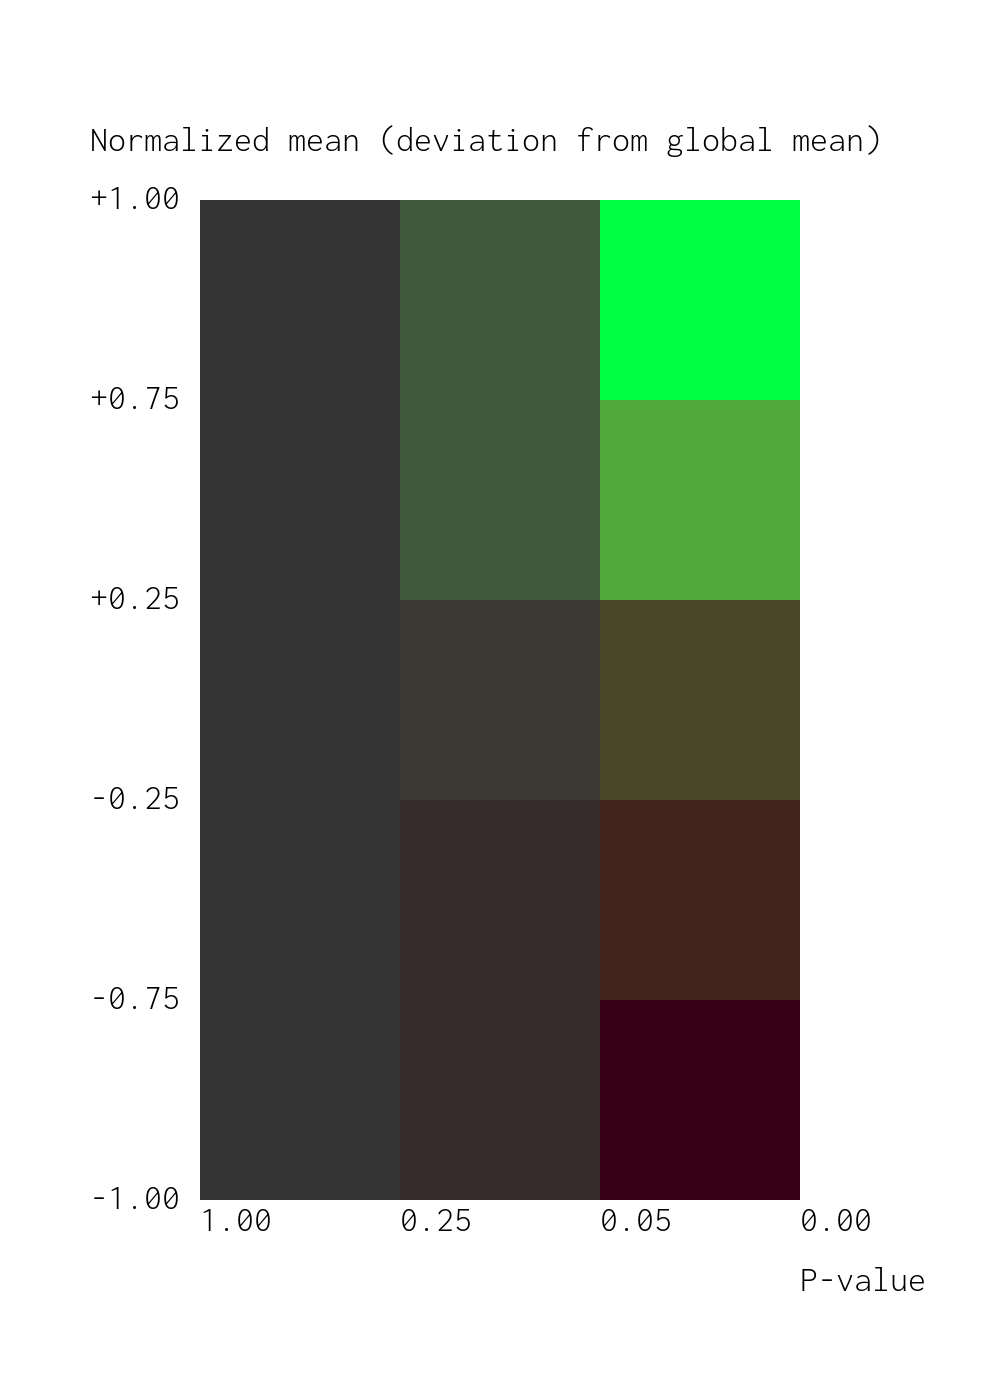

In [26]:
# Draw a legend

# Margins
x_margin = 200
y_margin = 200

# Ranges
p_value_range = [1, 0.25, 0.05, 0]
norm_mean_range = [-1, -0.75, -0.25, 0.25, 0.75, 1]

# Define the dimensions of the color legend
legend_width = len(p_value_range)
legend_height = len(norm_mean_range)

# Define the size of each cell in the legend
cell_width = 200
cell_height = 200

# Create a blank image for the legend
legend_image = Image.new('RGB', (2*x_margin + (legend_width-1) * cell_width, 2*y_margin+(legend_height-1) * cell_height), (255, 255, 255))
draw = ImageDraw.Draw(legend_image)

# Iterate over each cell in the legend
for i in range(legend_height-1):
    for j in range(legend_width-1):
        # Calculate the coordinates of the current cell
        x = x_margin+j * cell_width
        y = y_margin+i * cell_height

        # Calculate the values for norm_mean and p_value
        norm_mean = (norm_mean_range[i] + norm_mean_range[i+1])/2
        p_value = (p_value_range[j] + p_value_range[j+1])/2

        # Get the color for the current cell using the getColor() function
        color = getColor(-norm_mean, p_value)

        # Draw a filled rectangle with the color in the current cell
        draw.rectangle([(x, y), (x + cell_width - 1, y + cell_height - 1)], fill=color)

font = ImageFont.truetype(settings['font'], 36)

# Add labels for the x-axis
for j in range(legend_width):
    p_value = p_value_range[j]
    x = x_margin + j * cell_width
    y = y_margin + (legend_height-1) * cell_height
    label = f'{p_value:0.2f}'
    draw.text((x, y), label, fill=(0, 0, 0), font=font)
draw.text((x_margin + (legend_width-1) * cell_width, y_margin + (legend_height-1) * cell_height + 60), "P-value", fill=(0, 0, 0), font=font)

# Add labels for the y-axis
for i in range(legend_height):
    norm_mean = norm_mean_range[i]
    x = x_margin - 110
    y = y_margin + (legend_height-i-1) * cell_height - 22
    label = f'{norm_mean:+.2f}'
    draw.text((x, y), label, fill=(0, 0, 0), font=font)
draw.text((x_margin - 110, y_margin - 80), "Normalized mean (deviation from global mean)", fill=(0, 0, 0), font=font)

# Save the legend image as a JPG file
legend_image.save('output/color_legend.jpg')
display(legend_image)

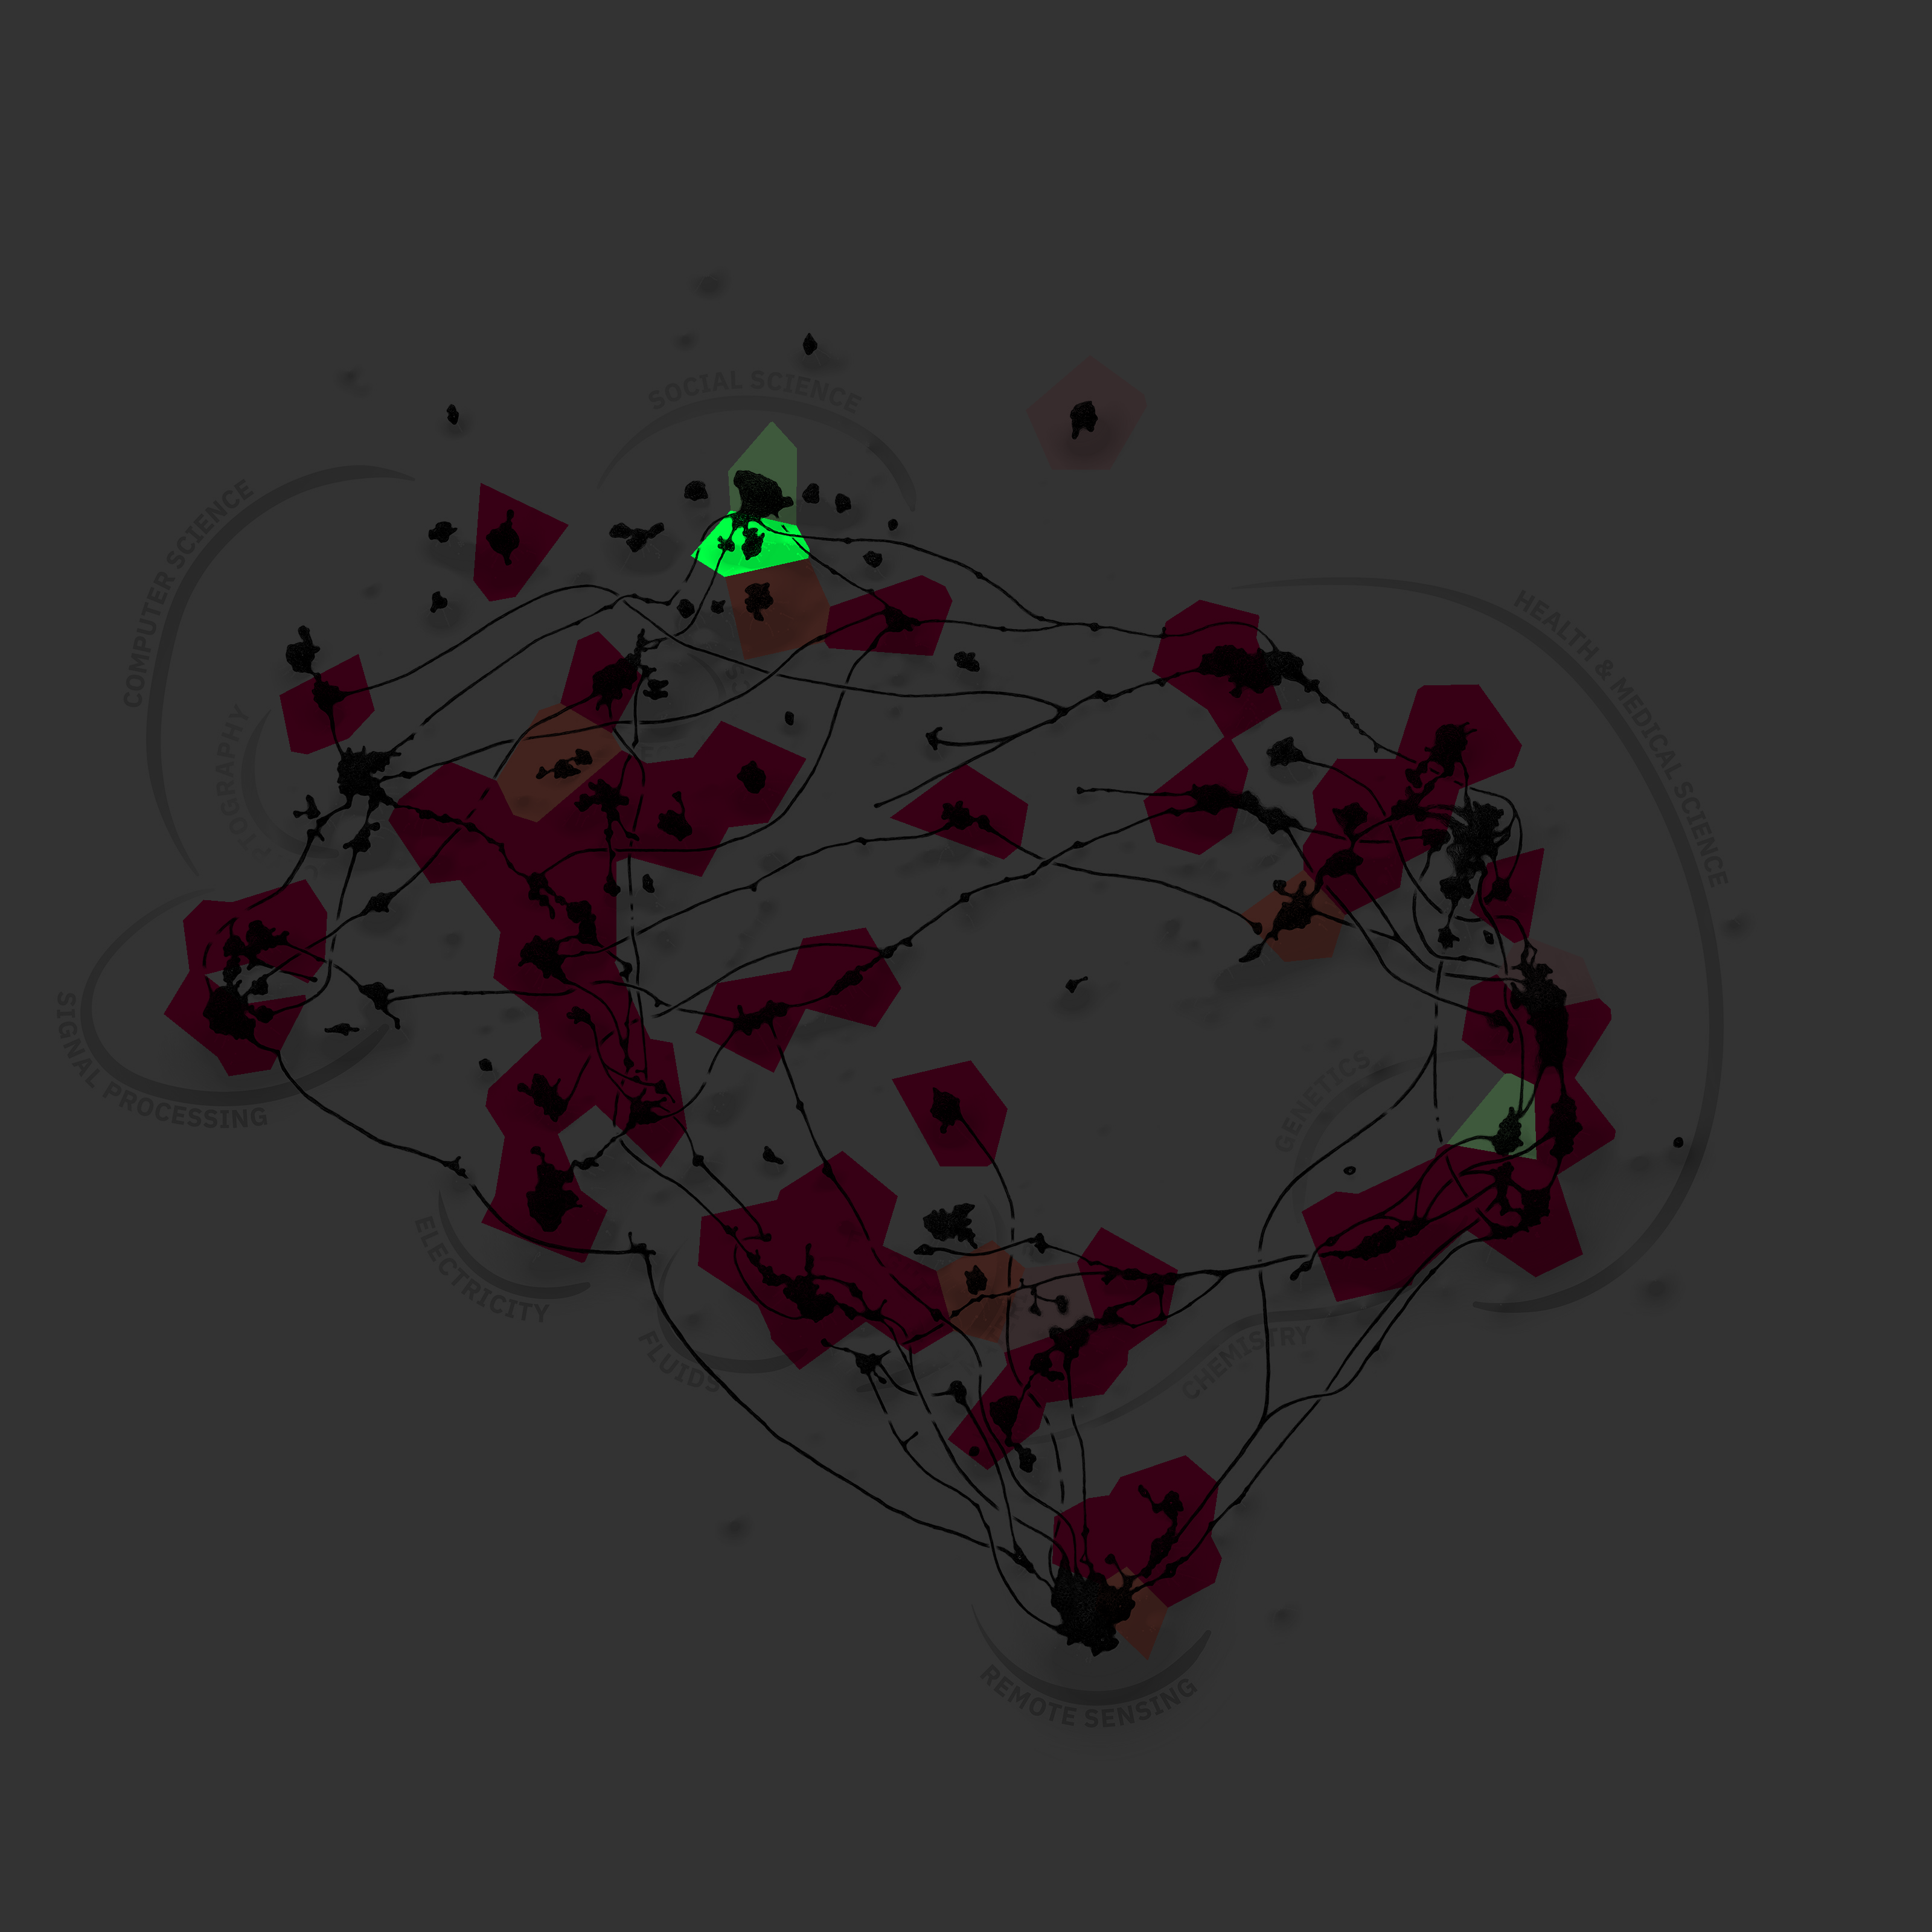

In [27]:
# Render visualization

drawNodes = False

# All centroids
all_centroids = np.concatenate((centroids, dummy_centroids))

# Init canvas
width = settings['canvas_size']
height = settings['canvas_size']
image = Image.new("RGB", (width, height), "#333333")
draw = ImageDraw.Draw(image)

# Draw Voronoi
vor = Voronoi(all_centroids)
for i in range(len(statcells)):
    result, p_value, mean, count = statcells[i]
    if count<30 or math.isnan(p_value):
            p_value = 1

    norm_mean = (mean-average_score)/average_score
    
    color = getColor(norm_mean, p_value)
    
    # Draw region
    region = vor.regions[vor.point_region[i]]
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        xy = []
        for point in polygon:
            x = width/2 + ((point[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
            y = height/2 + (-(point[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
            xy.append(x)
            xy.append(y)
        draw.polygon(xy, fill=color)

# Draw nodes if needed
if drawNodes:
    for index, row in df.iterrows():
        x = width/2 + ((row['x'] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
        y = height/2 + (-(row['y'] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
        r = settings['scale_ratio'] * row['size']
        draw_circle(x, y, r, "#000000")

# Background (we actually composite it over)
bgImg = Image.open(settings['background_image'])

# Composite
compositeImage = ImageChops.multiply(image, bgImg)

# Save
compositeImage.save(settings['output_file_basename']+" - voronoi.jpg", "JPEG")
    
display(compositeImage)